<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/ml_coding_interview_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micrograd

In [1]:
import numpy as np

In [2]:
# Lets start with Micro grad

class Value:

    def __init__(self, val, parents = (), op = None, label = None):
        self.val = val
        self.parents = parents
        self.op = op
        self.grad = 0
        self.label = label

    def __repr__(self):
        return f'Value: {self.val:.4f}' + (f'  :: Label: {self.label}' if self.label != None else '')

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __add__(self, other):

        if not isinstance(other, Value): other = Value(other, label = str(other))

        out = Value(self.val + other.val, (self, other), label = f'{self.label}+{other.label}')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        if not isinstance(other, Value): other = Value(other, label = str(other))
        out = Value(self.val * other.val, (self, other), label = f'{self.label}*{other.label}')

        def _backward():
            self.grad += other.val * out.grad
            other.grad += self.val * out.grad

        out._backward = _backward
        return out

    def __pow__(self, pow):
        out = Value(self.val ** pow, (self,), label = f'{self.label}**{pow}')
        def _backward():
            self.grad += pow*self.val**(pow-1) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        exp = np.exp(self.val)
        out = Value(exp, (self,), label = f'exp({self.label})')
        def _backward():
            self.grad += exp * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.val if self.val > 0 else 0, label = f'relu({self.label})')

        def _backward():
            self.grad += 0 if out.val else out.grad

        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.
        visited = set()
        dfs = []
        # breakpoint()
        def _dfs(node):

            if node in visited: return

            visited.add(node)

            for i in node.parents:
                _dfs(i)

            dfs.append(node)

        _dfs(self)
        topsort = reversed(dfs)

        for i in topsort:
            if not hasattr(i, '_backward'): continue
            i._backward()


In [3]:
x1, x2 = Value(-1.5, label = 'x1'), Value(1.3, label = 'x2')
w1, w2 = Value(4, label = 'w1'), Value(5, label = 'w2')
b = Value(0, label = 'b')
z = w1*x1 + w2*x2 + b
z.label = 'z'

# z.backward()
# w1.grad, w2.grad, b.grad
print(z)
yhat = ((2*z).exp() - 1)/((2*z).exp() + 1)
# yhat.label = 'yhat'
print(yhat)

yhat.backward()

yhat.grad, z.grad, w1.grad, w2.grad, b.grad

Value: 0.5000  :: Label: z
Value: 0.4621  :: Label: exp(z*2)+-1*exp(z*2)+1**-1


(1.0,
 0.7864477329659272,
 -1.1796715994488909,
 1.0223820528557053,
 0.7864477329659272)

In [4]:
import random

class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class Neuron(Module):
    def __init__(self, n_in):
        self.ws = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(0)

    def forward(self, x): # dot product + b: wx + b
        # breakpoint()
        return sum((a * b for a, b in zip(self.ws, x))) + self.b

    def __repr__(self):
        return f"Neuron containing: {self.ws}"

class Layer(Module):
    def __init__(self, n_in, n_out):
        # n_in: number of inputs
        # n_out: number of outputs desired in a layer
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def forward(self, x):
        return [n(x) for n in self.neurons]

    def __repr__(self): return f"Layer containing weights of shape: {len(self.neurons)}x{len(self.neurons[0].ws)}"


class MLP(Module):

    def __init__(self, lc = [], act = 'relu'):
        # assume lc - layer_config has n_in preppended
        self.layers = [Layer(lc[i-1], lc[i]) for i in range(1, len(lc))]

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        st = ''
        for i in self.layers:
            st += i.__repr__() + ' \n'
        return st

In [5]:
x = [Value(1, label = 'x1'), Value(1.5, label = 'x2'), Value(1.2, label = 'x3')]
neu = Neuron(3)
neu(x)

Value: 1.8940  :: Label: None*x1+0+None*x2+None*x3+None

In [6]:
x = [Value(1, label = 'x1'), Value(1.5, label = 'x2'), Value(1.2, label = 'x3')]
layer = Layer(3, 2)
inter = layer(x)
inter

[Value: -0.1218  :: Label: None*x1+0+None*x2+None*x3+None,
 Value: 1.1135  :: Label: None*x1+0+None*x2+None*x3+None]

In [7]:
x = [Value(1, label = 'x1'), Value(1.5, label = 'x2'), Value(1.2, label = 'x3')]
mlp = MLP((3, 2, 1))
yhat = mlp(x)

In [8]:
yhat[0].backward()
yhat[0].val

-0.8330107775570503

In [9]:
for layer in mlp.layers:
    for neu in layer.neurons:
        print([i.grad for i in neu.ws])

[0.5272679690160686, 0.790901953524103, 0.6327215628192824]
[-0.38744739074537704, -0.5811710861180656, -0.4649368688944524]
[-1.2862314400106958, 0.39959525395215145]


In [10]:
# batch norm
import torch
from torch import nn
from torch.nn import functional as F

class BN(nn.Module):

    def __init__(self, n_filters):
        super().__init__()
        self.running_mean = None
        self.running_std = None

        self.scale = nn.Parameter(torch.tensor(1.))
        self.shift = nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        # x.shape - bs, ch, h, w
        mean = x.mean((0, 1)).squeeze() #bs, h, w
        std = x.std((0, 1)).squeeze() #bs, h, w
        return self.scale*((x - mean)/std) + self.shift

In [11]:
bn = BN(4)
x = torch.randn(16, 4, 32, 32)
out = bn(x)
out.shape, out.mean(), out.std()

(torch.Size([16, 4, 32, 32]),
 tensor(6.4392e-10, grad_fn=<MeanBackward0>),
 tensor(0.9922, grad_fn=<StdBackward0>))

In [12]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [13]:
class Softmax():
    def __init__(self): pass

    def __call__(self, x):
        self.x = x
        x_exp = np.exp(x)
        x_exp_sum = x_exp.sum()

        self.es = x_exp/x_exp_sum
        return self.es

    def _backward(self):
        lsp, rsp = self.es, (np.eye(len(self.x)) - self.es).T
        return np.dot(lsp, rsp)

In [14]:
x = [0.14, 0.5, -0.8]
soft = Softmax()
es = soft(x)

In [15]:
es, es.sum()

(array([0.35411301, 0.50756059, 0.1383264 ]), 1.0)

In [16]:
x_grad = soft._backward()

In [17]:
x_grad

array([-0.04803496,  0.10541262, -0.26382157])

In [18]:
xx = torch.tensor(x, requires_grad = True)
y = F.softmax(xx)

y.sum().backward()

<ipython-input-18-bf3ebf7fce68>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(xx)


In [19]:
xx, xx.grad

(tensor([ 0.1400,  0.5000, -0.8000], requires_grad=True),
 tensor([2.1107e-08, 3.0253e-08, 8.2449e-09]))

# Perceptron and othe blocks from scratch (Dealing with matrices)

In [20]:
import numpy as np
import torch

from torch.nn import functional as F

import matplotlib.pyplot as plt

In [352]:
# create a dataset of 20 examples
# 3xs and 1ys
# create a ws and b
# sigmoid
# mse

In [28]:
def mse(yhat, y):
    return np.mean((yhat-y)**2)

def mse_grad(yhat, y):
    return (2/len(yhat))*(yhat - y)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_grad(act):
    return act*(1 - act)

def relu(z):
    return z * (z > 0)

def relu_grad(z):
    return (z > 0)

def softmax(z):
    exp_sum = np.exp(z).sum(-1)
    return np.exp(z)/np.expand_dims(exp_sum, axis=1)

def softmax_grad(acts):
    return acts * (1. - acts)

def cross_entropy(yhat, y):
    return y * -1 * np.log(yhat)

def cross_entropy_grad(yhat, y):
    return y * (-1/yhat)

In [423]:
ys = np.arange(0, 1, 1/20)

ys = np.random.uniform(low=0, high=1., size=(20,2))
xs = np.random.uniform(low= -1, high = 2, size = (20, 3))

# 3x2 matrix for 3 inputs and 2 outputs
ws = np.random.uniform(low = -1, high = 1, size = (3, 2))
bs = np.zeros((2))
# xs.shape, ys.shape, ws.shape, bs.shape

zs = xs.dot(ws) + bs
yhat = sigmoid(zs)
print(yhat.shape)

loss = mse(yhat, y)
print("Loss: ", loss)

dl_dyhat = mse_grad(yhat, y)
dyhat_dz = sigmoid_grad(yhat)
# dyhat_dz.shape
dl_dz = dyhat_dz * dl_dyhat
dl_dw = (1/xs.shape[0])*np.dot(xs.T, dl_dz)

lr = 0.5
ws += -lr*dl_dw
bs += -lr*dl_dz.mean(0)

(20, 2)
Loss:  0.243156526893116


In [15]:
def train(xs, ys, n_epochs = 100):

    lr = 0.7
    # 3x2 matrix for 3 inputs and 2 outputs
    ws = np.random.uniform(low = -1, high = 1, size = (xs.shape[1], ys.shape[1]))
    bs = np.zeros((ys.shape[1]))
    print(xs.shape, ys.shape, ws.shape, bs.shape)

    for i in range(n_epochs):

        # Forward Pass
        zs = xs.dot(ws) + bs
        yhat = sigmoid(zs)

        # Loss Calculation
        loss = mse(yhat, ys)
        if (i)%10 == 0:
            print(f"Epoch: {i+1}, Loss: {loss}")

        # Calculating Gradients
        dl_dyhat = mse_grad(yhat, ys)
        dyhat_dz = sigmoid_grad(yhat)
        dl_dz = dyhat_dz * dl_dyhat
        dl_dw = (1/xs.shape[0])*np.dot(xs.T, dl_dz) # dl_dz*dz_dw
        dl_db = dl_dz.mean(0) # 1

        # Backward Pass
        ws += -lr * dl_dw
        bs += -lr * dl_db

    return ws, bs

In [21]:
ys = np.random.uniform(low=0, high=1., size=(20,2))
xs = np.random.uniform(low= -4, high = 4, size = (20, 3))
trained_ws, trained_bs = train(xs, ys, 100)

(20, 3) (20, 2) (3, 2) (2,)
Epoch: 1, Loss: 0.17480770537172163
Epoch: 11, Loss: 0.14914855268778654
Epoch: 21, Loss: 0.12973814316934065
Epoch: 31, Loss: 0.11517636329801513
Epoch: 41, Loss: 0.10321831826716292
Epoch: 51, Loss: 0.09272226704806837
Epoch: 61, Loss: 0.08349640143061773
Epoch: 71, Loss: 0.07582077763916781
Epoch: 81, Loss: 0.0699662471142186
Epoch: 91, Loss: 0.06588078714386562


In [74]:
# 3, 4, 2
ys = np.random.uniform(low=0, high=1., size=(20,2))
xs = np.random.uniform(low= -10, high = 10, size = (20, 3))

w1 = np.random.uniform(low = -1, high = 1, size = (xs.shape[1], 4))
b1 = np.zeros((4))

w2 = np.random.uniform(low = -1, high = 1, size = (4, ys.shape[1]))
b2 = np.zeros((ys.shape[1]))

z1 = np.dot(xs, w1) + b1
a1 = sigmoid(z1)

z2 = np.dot(a1, w2) + b2
yhat = sigmoid(z2)
loss = mse(yhat, ys)

print("First Loss: ", loss)

dl_dyhat = mse_grad(yhat, ys)
dl_dyhat.shape

dyhat_dz2 = sigmoid_grad(yhat)
dyhat_dz2.shape

dl_dz2 = dl_dyhat * dyhat_dz2
dl_dz2.shape

# dl_dw2 = dl_dz2 * dz2_dw2
# dl_db2 = dl_dz2

dl_dw2 = (1/a1.shape[0]) * np.dot(a1.T, dl_dz2) # Done
dl_db2 = dl_dz2.mean(0) # Done

dl_dw2.shape, dl_db2.shape

# Now we have to calculate dz2_da1
# then dl_da1 = dl_dz2 * dz2_da1
w2.shape, dl_dz2.shape

# dz2_dz1 = w2
dl_da1 = np.dot(dl_dz2, w2.T)
dl_da1.shape

# dl_dz1 = dl_da1 * da1_dz1
da1_dz1 = sigmoid_grad(a1)
dl_dz1 = dl_da1 * da1_dz1
dl_dz1.shape

dl_dw1 = (1/z1.shape[0]) * np.dot(xs.T, dl_dz1) # Done
dl_db1 = dl_dz1.mean(0) # Done

dl_dw1.shape, dl_db1.shape

lr = 0.89

w1 += -lr * dl_dw1
b1 += -lr * dl_db1

w2 += -lr * dl_dw2
b2 += -lr * dl_db2

z1 = np.dot(xs, w1) + b1
a1 = sigmoid(z1)

z2 = np.dot(a1, w2) + b2
yhat = sigmoid(z2)
loss = mse(yhat, ys)

loss

First Loss:  0.08896005403578382


0.08859228406828024

In [71]:
def mlp_train(xs, ys, n_epochs = 100):

    lr = 0.7
    # 3x2 matrix for 3 inputs and 2 outputs
    w1 = np.random.uniform(low = -1, high = 1, size = (xs.shape[1], 4))
    b1 = np.zeros((4))

    w2 = np.random.uniform(low = -1, high = 1, size = (4, ys.shape[1]))
    b2 = np.zeros((ys.shape[1]))

    # print(xs.shape, ys.shape, ws.shape, bs.shape)

    for i in range(n_epochs):

        # Forward Pass
        z1 = np.dot(xs, w1) + b1
        a1 = relu(z1)

        z2 = np.dot(a1, w2) + b2
        yhat = sigmoid(z2)

        # Loss Calculation
        loss = mse(yhat, ys)
        if (i)%10 == 0:
            print(f"Epoch: {i+1}, Loss: {loss}")

        # Calculating Gradients
        dl_dyhat = mse_grad(yhat, ys)
        dyhat_dz2 = sigmoid_grad(yhat)

        dl_dz2 = dl_dyhat * dyhat_dz2

        # Activation to weight
        dl_dw2 = (1/a1.shape[0]) * np.dot(a1.T, dl_dz2) # Done
        dl_db2 = dl_dz2.mean(0) # Done

        # Activation to Activation
        dl_da1 = np.dot(dl_dz2, w2.T)
        da1_dz1 = relu_grad(z1)

        dl_dz1 = dl_da1 * da1_dz1

        dl_dw1 = (1/z1.shape[0]) * np.dot(xs.T, dl_dz1) # Done
        dl_db1 = dl_dz1.mean(0) # Done

        # Backward Pass
        w1 += -lr * dl_dw1
        b1 += -lr * dl_db1

        w2 += -lr * dl_dw2
        b2 += -lr * dl_db2

    return w1, b1, w2, b2

In [72]:
ys = np.random.uniform(low=0, high=1., size=(20,2))
xs = np.random.uniform(low= -4, high = 4, size = (20, 3))
mlp_parameters = mlp_train(xs, ys, 200)

Epoch: 1, Loss: 0.20880276427291705
Epoch: 11, Loss: 0.19286537214136576
Epoch: 21, Loss: 0.17876130479920377
Epoch: 31, Loss: 0.1684445768804895
Epoch: 41, Loss: 0.16049987459064366
Epoch: 51, Loss: 0.15302545114742697
Epoch: 61, Loss: 0.1460114353910063
Epoch: 71, Loss: 0.13947239740666803
Epoch: 81, Loss: 0.13341236039021864
Epoch: 91, Loss: 0.12781272182953737
Epoch: 101, Loss: 0.12263763136945331
Epoch: 111, Loss: 0.11781626826874629
Epoch: 121, Loss: 0.11331716968269956
Epoch: 131, Loss: 0.10911714064164271
Epoch: 141, Loss: 0.1051894469078983
Epoch: 151, Loss: 0.10149579563690976
Epoch: 161, Loss: 0.09801162402526392
Epoch: 171, Loss: 0.09472338810090418
Epoch: 181, Loss: 0.09159211982221711
Epoch: 191, Loss: 0.08874235951211558


In [109]:
# [x1, x2] -> [e1, e2] -> L
# dl_de = [dl_de1, dl_de2]
# de_dx = [de_dx1, de_dx2] = [de1_dx1 + de2_dx1, de1_dx2 + de2_dx2]
# dl_dx = [dl_de1 * de1_dx1 + dl_de2 * de2_dx1, dl_de1 * de1_dx2 + dl_de2 * de2_dx2]

def softmax(z):
    exp_sum = np.exp(z).sum(-1)
    return np.exp(z)/(np.expand_dims(exp_sum, axis=1) if len(z.shape) > 1 else exp_sum)

def cross_entropy(yhat, y):
    if len(y.shape) > 1:
        return (y * np.log(1/yhat)).sum(1).mean()
    else:
        return (y * np.log(1/yhat)).sum()

def cross_entropy_grad(yhat, y):
    if len(yhat.shape) > 1:
        return (y/yhat.shape[0]) * (-1/yhat)
    else:
        return y * (-1/yhat)

def softmax_grad(yhat): # Only support single element, does not support batchwise : TODO: Do batchwise

    # yhat.shape = [3] - num_classes
    # dl_de = [3] - dl_for_each_e - dl_de[0] = [dl_de1, dl_de2, dl_de3]
    # So now what needs to be done????
    # formulate de_dx matrix where we have dei_dxj for each e_i and x_j

    # e == yhat : yhat is the output of softmax act function
    # de_dx = yhat * (np.eye(yhat.shape[-1]) - yhat.T)

    # de_dx_unsummed = yhat * (np.eye(yhat.shape[-1]) - np.expand_dims(yhat, axis = 0).T)
    # return de_dx_unsummed
    return np.diag(yhat) - np.outer(yhat, yhat)

In [222]:
zs_t = torch.randn([1, 3], requires_grad = True)
ys_t = torch.tensor([[0, 1, 0]], dtype = torch.float32)

zs, ys = zs_t.detach().numpy()[0], ys_t.numpy()[0]

yhat = softmax(zs)
loss = cross_entropy(yhat, ys)
print(f"Loss: {loss}")

dloss_dyhat = cross_entropy_grad(yhat, ys) # Correct

dyhat_dz_unsummed = softmax_grad(yhat)

dl_dz = np.dot(dloss_dyhat, dyhat_dz_unsummed)

dl_dz

Loss: 0.6789330840110779


array([ 0.31114352, -0.49284223,  0.18169868], dtype=float32)

In [223]:
yhat_t = F.softmax(zs_t, dim = 1)
yhat_t.retain_grad()
loss = (ys_t * torch.log(1./yhat_t)).sum(1).mean()
print(f"Loss: {loss}")
loss.backward()
zs_t.grad, yhat_t.grad

Loss: 0.6789330840110779


(tensor([[ 0.3111, -0.4928,  0.1817]]), tensor([[-0.0000, -1.9718, -0.0000]]))

# TODO: Conv Layer from scratch

# TODO: Norm Layers From Scrath - BN and LN

# TODO: Linear Layer from scratch


In [143]:
import numpy as np

import torch
import torch.nn.functional as F

class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def step(self, *args, **kwargs): pass

class Linear(Module):

    def __init__(self, nin, nout):

        self.nin = nin; self.nout = nout

        self.w = torch.randn(nin, nout)
        self.b = torch.zeros(nout)

    def forward(self, x):

        # x.shape = (bs, n_features)
        # ws.shape = (n_features, out_features)
        # returns shape of (bs, out_features)
        self.input = x
        self.out = self.input@self.w + self.b
        return self.out

    def backward(self):

        # out_grads of shape: [bs, n_out] : out_features
        # dot product between input and out_grads
        # input shape = bs, n_in : out_grads shape = [bs, n_out]


        '''
        Formulas:
            Input: X
            Output: Z
            Weights: w
            Bias: b

            dl_dw = (X.T @ dl_dz)/batch_size # Mean
            dl_db = dl_dz.mean()
            dl_dx = dl_dz @ w.T
        '''
        bs = self.input.shape[0]

        # Lets calculate dl_dw
        self.w.grad = (self.input.T @ self.out.grad) * (1/bs)

        # Calculate dl_db
        self.b.grad = self.out.grad.mean(0)

        # Claculate dl_dx
        self.input.grad = self.out.grad @ self.w.T

    def step(self, lr):

        self.w += -lr * self.w.grad
        self.b += -lr * self.b.grad

class ReLU(Module):
    def forward(self, x):
        self.input = x
        self.mask = (self.input > 0).to(torch.float32)
        self.out = self.mask * self.input
        return self.out

    def backward(self):

        self.input.grad = self.mask * self.out.grad

class Sigmoid(Module):

    def forward(self, x):
        self.input = x
        self.out = 1/(1 + torch.exp(-1*x))
        return self.out

    def backward(self):
        local_grad = self.out * (1 - self.out)
        self.input.grad = local_grad * self.out.grad

class Softmax(Module):

    def forward(self, x):
        self.input = x
        self.out = self.input.exp()/self.input.exp().sum(1)[:, None]
        return self.out

    def backward(self):
        # self.input.shape == self.out.shape = bs, c
        bs, c = self.input.shape

        out_g = self.out.grad # (bs, c)

        id_m = torch.eye(c, dtype = torch.float32) # (c, c)
        id_m = id_m[None, :, :] # (1, c, c) - For broadcasting
        rhp = (id_m - self.out[:, None, :]) # (bs, c, c)
        lhp = self.out[:, :, None] # (bs, c, 1) for column wise broadcasting
        local_grad = lhp * rhp # (bs, c, c) - un summed
        dl_dinput = local_grad @ self.out.grad[:, :, None] # (bs, c, c) @ (bs, c, 1) - bs, c, 1

        self.input.grad = dl_dinput.squeeze()

class CrossEntropyLoss(Module):

    def forward(self, yhat, y):
        self.input = yhat
        self.y = y
        return (y * -yhat.log()).sum(1).mean()

    def backward(self):
        bs = self.input.shape[0]
        self.input.grad = (1/bs) * (-self.y/self.input)

class MSELoss(Module):
    def forward(self, yhat, y):
        self.input = yhat
        self.y = y
        self.out = ((yhat - y) ** 2).mean()
        return self.out

    def backward(self):
        grad = (2/self.input.shape[0]) * (self.input - self.y)
        self.input.grad = grad

In [115]:
x = torch.randn(32, 5)
y = torch.tensor(np.random.uniform(low= 0, high = 1, size = (32, 2)), dtype = torch.float32)

l1 = Linear(5, 3)
a1 = ReLU()
l2 = Linear(3, 2)
a2 = Sigmoid()

loss_func = MSELoss()

for i in range(1000):
    o1 = l1(x)
    o2 = a1(o1)
    o3 = l2(o2)
    o4 = a2(o3)

    loss = loss_func(o4, y)
    if i%50 == 0: print(f"Ep: {i}, Loss: {loss}")
    loss_func.backward()
    a2.backward()
    l2.backward()
    a1.backward()
    l1.backward()

    for l in [l1, a1, l2, a2]: l.step(lr = 0.8)
    x.grad = None
print(f"Ep: {i}, Loss: {loss}")

Ep: 0, Loss: 0.1449497640132904
Ep: 50, Loss: 0.13988332450389862
Ep: 100, Loss: 0.13490402698516846
Ep: 150, Loss: 0.12993314862251282
Ep: 200, Loss: 0.12498801201581955
Ep: 250, Loss: 0.11912492662668228
Ep: 300, Loss: 0.11209198087453842
Ep: 350, Loss: 0.10667120665311813
Ep: 400, Loss: 0.10068228095769882
Ep: 450, Loss: 0.0948733240365982
Ep: 500, Loss: 0.09017761051654816
Ep: 550, Loss: 0.08661936223506927
Ep: 600, Loss: 0.0839461237192154
Ep: 650, Loss: 0.08184453099966049
Ep: 700, Loss: 0.08003367483615875
Ep: 750, Loss: 0.07836124300956726
Ep: 800, Loss: 0.07684402167797089
Ep: 850, Loss: 0.07548607885837555
Ep: 900, Loss: 0.07419560849666595
Ep: 950, Loss: 0.07296980172395706
Ep: 999, Loss: 0.07183732837438583


In [136]:
yhat_t = torch.randn((2, 3), requires_grad = True)
y_t = torch.Tensor([[1., 0, 0], [0., 1., 0]])

yhat_t_s = F.softmax(yhat_t, dim = 1)
yhat_t_s.retain_grad()
loss = (-y_t * yhat_t_s.log()).sum(1).mean()
loss

tensor(1.9451, grad_fn=<MeanBackward0>)

In [137]:
loss.backward()
yhat_t_s.grad, yhat_t.grad

(tensor([[-2.7648, -0.0000, -0.0000],
         [-0.0000, -4.4235, -0.0000]]),
 tensor([[-0.4096,  0.3303,  0.0793],
         [ 0.3306, -0.4435,  0.1128]]))

In [140]:
yhat = yhat_t.detach().clone()
y = y_t.clone()
softm = Softmax()
loss_func = CrossEntropyLoss()
yhat_s = softm(yhat)
loss_func(yhat_s, y)

tensor(1.9451)

In [141]:
loss_func.backward()
yhat_s.grad

tensor([[-2.7648, -0.0000, -0.0000],
        [-0.0000, -4.4235, -0.0000]])

In [142]:
softm.backward()
yhat.grad

tensor([[-0.4096,  0.3303,  0.0793],
        [ 0.3306, -0.4435,  0.1128]])

# Random Diffusion Visualizations

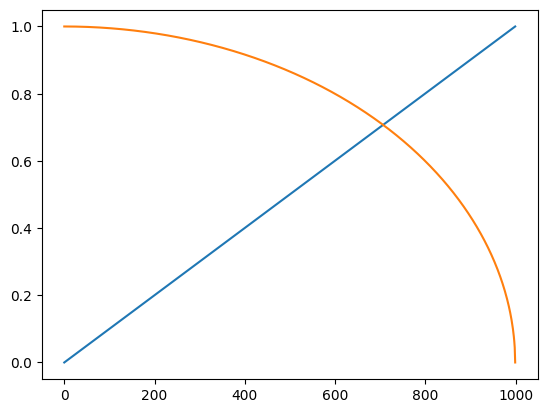

In [1]:
import torch
from matplotlib import pyplot as plt

# This is alpha_bar_t
'''
x0 = torch.randn(32, 3, 32, 32)
N = torch.randn_like(x0)
xt = (alpha_bar_t.sqrt())*x0 + (1 - alpha_bar_t).sqrt()*N

a = (alpha_bar_t.sqrt())
b = (1 - alpha_bar_t).sqrt()
'''

b = torch.linspace(0, 1, 1000)
alpha_bar_t = 1 - b**2

plt.plot(b)
plt.plot(alpha_bar_t.sqrt())

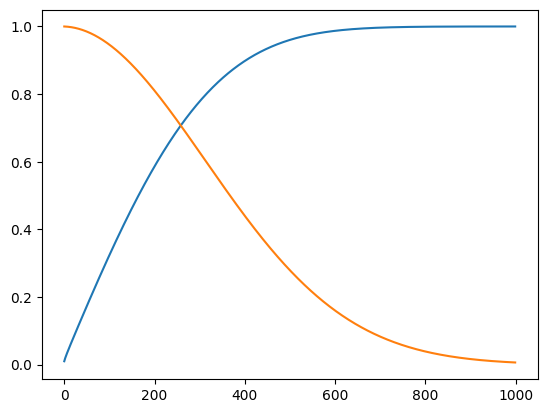

In [3]:
# Lets say sqrt(beta_t) is linear

beta_sqrt = torch.linspace(0.0001, 0.02, 1000)
beta = beta_sqrt #** 2
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

plt.plot((1-alpha_bar).sqrt())
plt.plot(alpha_bar.sqrt())

# Only Forwards

In [2]:
from einops import rearrange
import torch
from torch import nn

class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class Conv2dFilter(Module):

    def __init__(self, in_c, kernel_size = 2):

        self.in_c = in_c
        self.kernel_size = kernel_size

        total_w_size = kernel_size**2 * in_c
        self.w = nn.Linear(total_w_size, 1)

    def forward(self, x):
        # x is of shape bs, channels, h, w
        ks = self.kernel_size

        i, j = ks, ks
        bs, c, h, w = x.shape
        acts = []

        while i <= x.shape[-2]:
            j = ks
            while j <= x.shape[-1]:

                x_window = x[:, :, i-ks:i, j-ks:j] # bs, c, ks, ks
                x_window = x_window.reshape(bs, -1) # bs, c*ks*ks
                acts.append(x_window[:, None, :])
                j += 1
            i += 1

        nh, nw = h - (1 + ks//2), w - (1 + ks//2)
        acts = torch.cat(acts, dim = 1) # bs, nh*nw, c
        fin_acts = self.w(acts).squeeze() # bs, nh*nw, 1

        return rearrange(fin_acts, 'b (i j)-> b i j', i = nh, j = nw)

In [207]:
x = torch.randn(2, 3, 4, 4)
filter = Conv2dFilter(3, 3)
out = filter(x)
out.shape, x.mean(), x.std()

(torch.Size([2, 2, 2]), tensor(0.0352), tensor(0.9435))

In [17]:
class LayerNorm(Module):

    def __init__(self, nc, eps = 1e-05):
        self.nc = nc
        self.w = torch.ones(nc, requires_grad = True)
        self.b = torch.zeros(nc, requires_grad = True)
        self.eps = eps

    def forward(self, x: torch.Tensor):
        # x.shape = (bs, n, c)
        mean = x.mean(-1, keepdim = True)
        var = ((x - mean)**2).mean(-1, keepdim = True)
        st_dev = (var + self.eps).sqrt()

        norm = (x - mean)/st_dev

        return self.w * norm + self.b

class BatchNorm(Module):
    def __init__(self, nc, eps = 1e-05):
        self.nc = nc
        self.w = torch.ones(nc)
        self.b = torch.zeros(nc)
        self.eps = eps
        self.mean = None
        self.std = None

        self.ema_coeff = 0.9

        self.training = True

    def eval(self):
        self.training = False

    def forward(self, x):
        # x.shape = (bs, n, c)
        mean = x.mean(0, keepdim = True) # (1, n, c)
        var = ((x - mean)**2).mean(0, keepdim = True) # (1, n, c)
        st_dev = (var + self.eps).sqrt()

        if self.training:
            if self.mean == None: self.mean = torch.zeros_like(mean)
            if self.std == None: self.std = torch.zeros_like(st_dev)

            self.mean = self.ema_coeff * self.mean + (1 - self.ema_coeff)*mean
            self.std = self.ema_coeff * self.std + (1 - self.ema_coeff)*st_dev

        norm = (x - self.mean)/self.std

        return self.w * norm + self.b

In [15]:
bn = BatchNorm(20)

In [16]:
for i in range(50):
    x = 3*torch.randn(32, 16, 20)
    norm = bn(x)
    if i%10 == 0:
        print(x.mean(), x.std())
        print("Norm: ", norm.mean(), norm.std())

tensor(-0.0257) tensor(2.9973)
Norm:  tensor(-0.0863) tensor(10.1482)
tensor(0.0242) tensor(2.9970)
Norm:  tensor(0.0118) tensor(1.4870)
tensor(-0.0014) tensor(2.9905)
Norm:  tensor(-0.0020) tensor(1.1444)
tensor(-0.0410) tensor(3.0482)
Norm:  tensor(-0.0158) tensor(1.0745)
tensor(-0.0208) tensor(3.0283)
Norm:  tensor(-0.0067) tensor(1.0394)


In [24]:
class MomentumOpt:
    def __init__(self, model, lr, p = 0.9):

        self.lr = lr
        self.p = p
        self.model = model

        self.velocities = {}
        for name, param in self.model.named_parameters():
            self.velocities[name] = torch.zeros_like(param)

    def step(self, model: nn.Module): # TODO: Correct the implementation pls

        for name, param in model.named_parameters():
            grad = param.grad.data
            ve = self.velocities[name]
            updated_ve =  grad + self.p * ve
            self.velocities[name] = updated_ve
            param.data += -self.lr * updated_ve

class RMSProp:

    def __init__(self, model, lr, beta, eps = 1e-8):

        self.model = model
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.grad_squared_ema = {} # EMA

        for name, param in self.model.named_parameters():
            self.grad_squared_ema[name] = torch.zeros_like(param.data)

    def step(self):

        for name, param in self.model.named_parameters():

            grad = param.grad.data

            grad_s_ema = self.grad_squared_ema[name]
            grad_s_ema_updated = (1 - self.beta)*grad**2 + beta*grad_s_ema
            self.grad_squared_ema[name] = grad_s_ema_updated

            param.data += -self.lr * (param.grad.data/(grad_s_ema_updated.sqrt() + self.eps))

class AdamW:

    def __init__(self, model, lr, wd = 1e-02, betas = (0.9, 0.999), eps = 1e-08):

        self.model = model
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.wd = wd

        self.momentum = {}
        self.rms_prop = {}

        self.t = 0

        for name, param in self.model.named_parameters():
            self.momentum[name] = torch.zeros_like(param.data)
            self.rms_prop[name] = torch.zeros_like(param.data)

    def step(self):

        # step update = param.data += -lr * ((momentum_step/rms_prop_step) - wd*param.data)

        def beta_correction(term, beta):
            return term/(1. - beta**self.t)

        for name, param in self.model.named_parameters():

            if param.grad == None: continue

            grad = param.grad.data
            updated_v = grad*(1-self.betas[0]) + self.momentum[name]*self.betas[0]
            updated_rms_prop = (grad**2)*(1-self.betas[1]) + self.rms_prop[name]*self.betas[1]

            self.momentum[name] = updated_v; self.rms_prop[name] = updated_rms_prop

            update = (self.wd*param.data + beta_correction(updated_v, self.betas[0])/(beta_correction(updated_rms_prop, self.betas[1]).sqrt() + self.eps))

            param.data += -self.lr*update

In [36]:
from torch import nn
import numpy as np
from einops import rearrange

class SelfAttention(nn.Module):
    def __init__(self, dim = 768):

        # norm -> attn -> proj -> add
        super().__init__()
        self.dim = dim
        self.kqv = nn.Linear(self.dim, self.dim*3, bias = False)
        self.norm = nn.LayerNorm(self.dim)
        self.proj = nn.Linear(self.dim, self.dim)

    def forward(self, x, causal = False): # as done in stable diffusion paper, except they used group norm rather than layer norm

        # x.shape = (bs, n, c)

        inp = self.norm(x)
        kqv = self.kqv(inp) # bs, n, 3*c
        k, q, v = kqv.chunk(3, dim = -1)

        # k - (bs, n, c), q - (bs, n, c)
        scale = 1/np.sqrt(x.shape[-1])
        attn_scores = (q@k.transpose(1, -1))*(1/scale) # (bs, n, n)

        if causal:
            mask = torch.triu(torch.ones_like(attn_scores), diagonal = 0)
            attn_scores.masked_fill(mask == 1, float('-inf'))

        attn_scores = F.softmax(attn_scores, dim = -1) # (bs, n, n)
        res = attn_scores @ v # bs, n, n @ bs, n, c -> bs, n, c

        return self.proj(res)

class MultiHeadAttention(nn.Module):

    def __init__(self, dim, n_head = 4):
        assert dim%n_head == 0

        self.dim = dim
        self.n_head = n_head
        self.kqv = nn.Linear(dim//n_head, 3*dim//n_head, bias = False)
        self.norm = nn.LayerNorm(dim)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x, causal = False):

        # norm -> break_to_multiple_heads -> attn_calculation -> concat all the heads -> proj -> return
        # x.shape = (bs, n, c)
        inp = x
        k, q, v = self.kqv(inp).chunk(3, dim = -1)

        k = rearrange(k, 'b n (c h) -> b h n c', h = self.n_heads) # bs, h, n, c/h
        q = rearrange(q, 'b n (c h) -> b h n c', h = self.n_heads) # bs, h, n, c/h
        v = rearrange(v, 'b n (c h) -> b h n c', h = self.n_heads) # bs, h, n, c/h

        scale = 1/np.sqrt(x.shape[-1])
        attn_scores = (q@k.transpose(1, -1))*(1/scale) # (bs, h, n, n)

        if causal:
            mask = torch.triu(torch.ones_like(attn_scores), diagonal = 0)
            attn_scores.masked_fill(mask == 1, float('-inf'))

        attn_scores = F.softmax(attn_scores, dim = -1) # (bs, h, n, n)
        res = attn_scores @ v # bs, h, n, n @ bs, h, n, c/h -> bs, h, n, c/h

        res = rearrange(res, 'b h n c -> b n (c h)', h = self.n_heads) # bs, h, n, c/h
        return res

class EncoderBlock(nn.Module):

    def __init__(self, dim, attn_block: nn.Module = SelfAttention):

        # attn(norm -> self_attn -> lin) -> add -> norm -> lin -> act -> lin
        super().__init__()
        self.dim = dim
        self.attn = attn_block(dim = dim)
        self.mlp = nn.Sequential(nn.LayerNorm(dim),
                                 nn.Linear(dim, dim),
                                 nn.GELU(approximate = 'tanh'),
                                 nn.Linear(dim, dim))

    def forward(self, x):
        attn_op = self.attn(x)
        x = x + attn_op
        return x + self.mlp(x)

In [22]:
a = torch.randn(4, 32, 64)
a.transpose(1, -1).shape

torch.Size([4, 64, 32])

In [35]:
matrix = torch.ones((2, 3, 3))
torch.triu(matrix, diagonal=1)

tensor([[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]]])

In [39]:
import math
  # points_dist = tsteps[:, None] * points[None, :].exp()
  # return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

In [54]:
# POSITIONAL EMBEDDIGNS
nsteps = 20; max_steps = 100; nemb = 64

tsteps = torch.linspace(-10, 10, nsteps)
points = -1*math.log(max_steps) * torch.linspace(0, 1, nemb//2).exp()
freqs = tsteps[:, None] * points[None, :]
out = torch.cat([torch.sin(freqs), torch.cos(freqs)], dim = -1)
out.shape

torch.Size([20, 64])

In [52]:
class LoRALinear()

torch.Size([20, 64])